<a href="https://colab.research.google.com/github/dmunozbe/TFM_DataScience/blob/main/Forecasting/08.%20Nou%20Barris/Forecasting_(Indicador_74).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Forecasting**




**Forecasting** es el proceso de predecir eventos futuros basados en patrones históricos y datos existentes.

El objetivo principal es el de hacer predicciones precisas sobre el futuro utilizando datos pasados y presentes y se utiliza en una amplia variaedad de constextos, como en finanzas, meteorologia, ventas entre otros

Se realizaran comprobaciones de cointegracion, estacionariedad, para determinar que modelo aplicar entre los seleccionados:

* Modelos VAR (Vector Autoregressive)
* Modelos VARMA (Vector Autoregressive Moving Average)
* Modelos VARMAx (VARMA con Variables Exógenas)
* Modelos VECM (Vector Error Correlation Model)

##Importar bibliotecas

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn import metrics


import warnings
warnings.filterwarnings("ignore")

##Carga de datos

In [2]:
# Cargar datos
data = pd.read_csv('/content/drive/MyDrive/UOC/TFM/Datasets definitivos/Final.csv')
data.head()

,Any,Trimestre,Mes,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Compraventa_Unitario,ParadosReg,Estudios_Obligatorios,ConsumResidencial,Pm25,Pm10,Participacion,AñosEspVida,Internet,Movil,Index_Turisme,m² por habitante
0,2014,1,1,1,Ciutat Vella,1,el Raval,2813.0,4588,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2
1,2014,1,2,1,Ciutat Vella,1,el Raval,2813.0,4539,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2
2,2014,1,3,1,Ciutat Vella,1,el Raval,2813.0,4572,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2
3,2014,2,4,1,Ciutat Vella,1,el Raval,2948.8,4510,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2
4,2014,2,5,1,Ciutat Vella,1,el Raval,2948.8,4379,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2


In [3]:
print(data.dtypes)

Any                        int64
Trimestre                  int64
Mes                        int64
Codi_Districte             int64
Nom_Districte             object
Codi_Barri                 int64
Nom_Barri                 object
Compraventa_Unitario     float64
ParadosReg                 int64
Estudios_Obligatorios    float64
ConsumResidencial        float64
Pm25                     float64
Pm10                     float64
Participacion            float64
AñosEspVida              float64
Internet                 float64
Movil                    float64
Index_Turisme            float64
m² por habitante         float64
dtype: object


## Analisis por grupo de indicadores (Movil)

### Preparacion de datos

In [4]:
df_sel = data[['Any','Trimestre','Mes','Codi_Districte','Nom_Districte','Codi_Barri','Nom_Barri','Compraventa_Unitario','Movil']]

In [5]:
df_cont = df_sel.dropna()

In [6]:
df_cont.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6132 entries, 1752 to 7883
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Any                   6132 non-null   int64  
 1   Trimestre             6132 non-null   int64  
 2   Mes                   6132 non-null   int64  
 3   Codi_Districte        6132 non-null   int64  
 4   Nom_Districte         6132 non-null   object 
 5   Codi_Barri            6132 non-null   int64  
 6   Nom_Barri             6132 non-null   object 
 7   Compraventa_Unitario  6132 non-null   float64
 8   Movil                 6132 non-null   float64
dtypes: float64(2), int64(5), object(2)
memory usage: 479.1+ KB


In [7]:
# Creamos la variable de fecha de la siguiente manera:
# Agregar un día fijo para cada mes, por ejemplo, el día 1
df_cont['Fecha'] = pd.to_datetime(df_cont['Any'].astype(str) + '-' + df_cont['Mes'].astype(str) + '-1')

In [8]:
# Modificamos el indice del dataset por la fecha
df_contI = df_cont.set_index('Fecha')

In [9]:
df_contI.head()

,Any,Trimestre,Mes,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Compraventa_Unitario,Movil
Fecha,,,,,,,,,
2016-01-01,2016,1,1,1,Ciutat Vella,1,el Raval,2813.0,96.3
2016-02-01,2016,1,2,1,Ciutat Vella,1,el Raval,2813.0,96.3
2016-03-01,2016,1,3,1,Ciutat Vella,1,el Raval,2813.0,96.3
2016-04-01,2016,2,4,1,Ciutat Vella,1,el Raval,2948.8,96.3
2016-05-01,2016,2,5,1,Ciutat Vella,1,el Raval,2948.8,96.3


### Analisis Exploratorio

Filtramos los datos por el distrito de Nou Barris -> Codi_Districte = 8

In [10]:
df_contFiltrado = df_contI[df_contI['Codi_Districte'] == 8]

In [11]:
# Agrupamos los datos
df =df_contFiltrado.drop(columns=['Any','Trimestre','Mes','Codi_Districte','Nom_Districte','Codi_Barri','Nom_Barri']).groupby('Fecha').mean()

In [12]:
df.head()

,Compraventa_Unitario,Movil
Fecha,,
2016-01-01,1511.900000,91.2
2016-02-01,1511.900000,91.2
2016-03-01,1511.900000,91.2
2016-04-01,1633.069231,91.2
2016-05-01,1633.069231,91.2


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 84 entries, 2016-01-01 to 2022-12-01
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Compraventa_Unitario  84 non-null     float64
 1   Movil                 84 non-null     float64
dtypes: float64(2)
memory usage: 2.0 KB


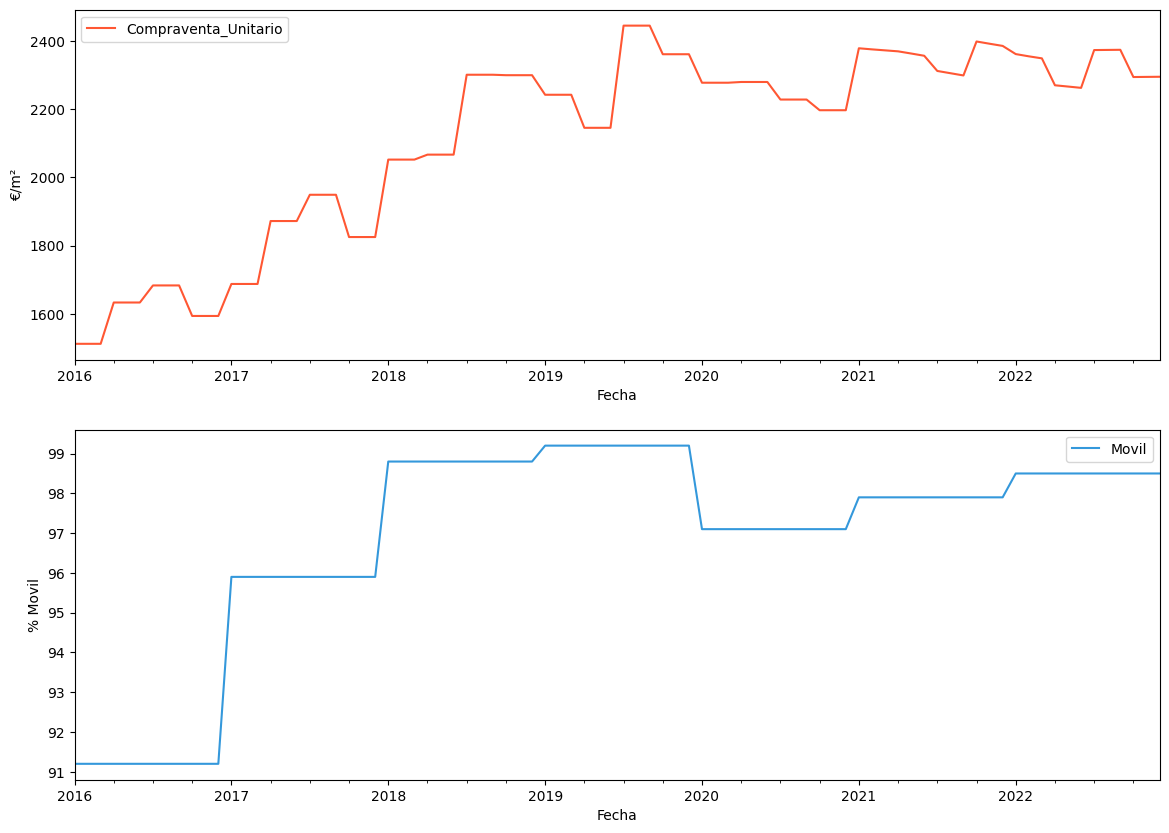

In [14]:
fig, axes = plt.subplots(nrows = int(len(df.columns)), ncols = 1, dpi = 100, figsize = (14,10))
unidades = ['€/m²','% Movil']
colores = ['#FF5733','#3498DB']

for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df[col].plot(color = colores[i], legend = True, ax = ax)
    ax.set_ylabel(unidades[i])  # Establecer etiqueta del eje y
plt.show()

Cada una de las series tiene patrones de tendencia muy diferentes entre si

In [15]:
corr=df.corr()
corr

,Compraventa_Unitario,Movil
Compraventa_Unitario,1.000000,0.868555
Movil,0.868555,1.000000


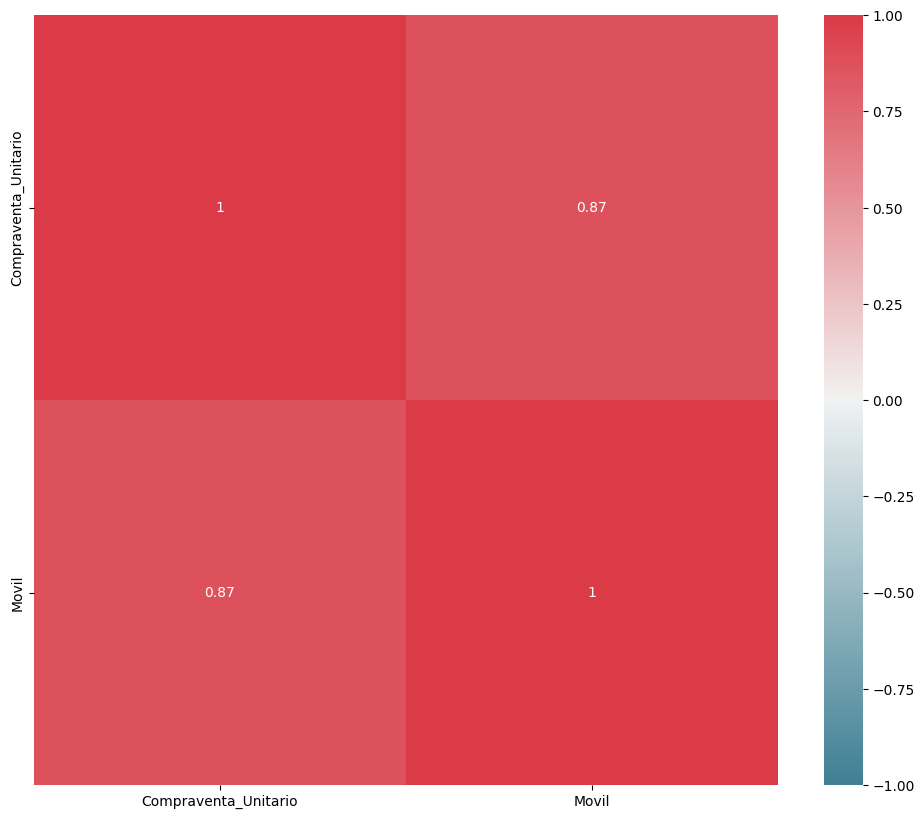

In [16]:
import seaborn as sb
fig, ax = plt.subplots(figsize=(12, 10))

sb.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True,vmax=1, vmin=-1, cmap =sb.diverging_palette(220, 10, as_cmap=True),center=0,ax=ax )
plt.show()

La correlación entre "Compraventa_Unitario" y "Movil" es de 0.868555, lo que sugiere una correlación bastante alta entre estas dos variables en el modelo.

### Dividir los datos en conjunto de Entrenamiento y Prueba


In [17]:
fecha_division = '2022-07-01'

X_train, X_test = df[df.index<fecha_division], df[df.index>=fecha_division]
print(X_train.shape, X_test.shape)


(78, 2) (6, 2)


Los modelos siguientes se ajustarán al conjunto de entrenamiento X_train y luego se utilizará el modelo para pronosticar las observaciones futuras. Estos pronósticos se compararán con los datos reales del conjunto de prueba.



###Test de Cointegracion

Determinaremos si las dos variables estan relacionadas entre si y si esa relacion es duradera o no

In [18]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df):
    res = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = res.lr1
    cvts = res.cvt[:, d[str(1-0.05)]]
    def adjust(val, length= 6):
        return str(val).ljust(length)
    print('Column Name   >  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), '> ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

In [19]:
cointegration_test(X_train[['Compraventa_Unitario','Movil']])

Column Name   >  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Compraventa_Unitario >  13.12     > 12.3212   =>   True
Movil  >  0.0       > 4.1296    =>   False


* **Compraventa_Unitario** muestra evidencia de cointegración, lo que sugiere que las variables incluidas tienen una tendencia a largo plazo a moverse juntas, manteniendo una relación de equilibrio.
* **Movil** no muestra evidencia de cointegración, lo que significa que las series relacionadas no tienden a volver a un equilibrio común a largo plazo bajo el modelo actual.

Para un análisis conjunto, dado que una de las series esta cointegrada y la otra no, se consideran principalmente 2 modelos, VAR y VECM



### Prueba de estacionariedad

Necesitamos que los datos sean estacionarios para poder usar el modelo VAR. Vamos a averiguarlo haciendo un Test de Dickey-Fuller aumentado, a cada variable univariante que tiene nuestro dataset.

In [20]:
import statsmodels.tsa.stattools as sts

In [21]:
def augmented_dickey_fuller_statistics(time_series):
  result = sts.adfuller(time_series.values)
  print('p-value: %f' % result[1])

print('Test de Dickey-Fuller Aumentado:')
for i in range(len(X_train.columns)):
  print('Serie de tiempo',X_train.columns[i])
  augmented_dickey_fuller_statistics(X_train.iloc[:,i])

Test de Dickey-Fuller Aumentado:
Serie de tiempo Compraventa_Unitario
p-value: 0.260113
Serie de tiempo Movil
p-value: 0.314378


Los p-valores son mayores que 0.05, con lo cual no se rechaza la hipótesis nula de que la serie no es estacionaria. Habría que transformar los datos porque no se puede confirmar estacionariedad.

In [22]:
#Diferenciando por primera vez
X_train_transformed=X_train.diff().dropna()
X_train_transformed.head()

,Compraventa_Unitario,Movil
Fecha,,
2016-02-01,0.000000,0.0
2016-03-01,0.000000,0.0
2016-04-01,121.169231,0.0
2016-05-01,0.000000,0.0
2016-06-01,0.000000,0.0


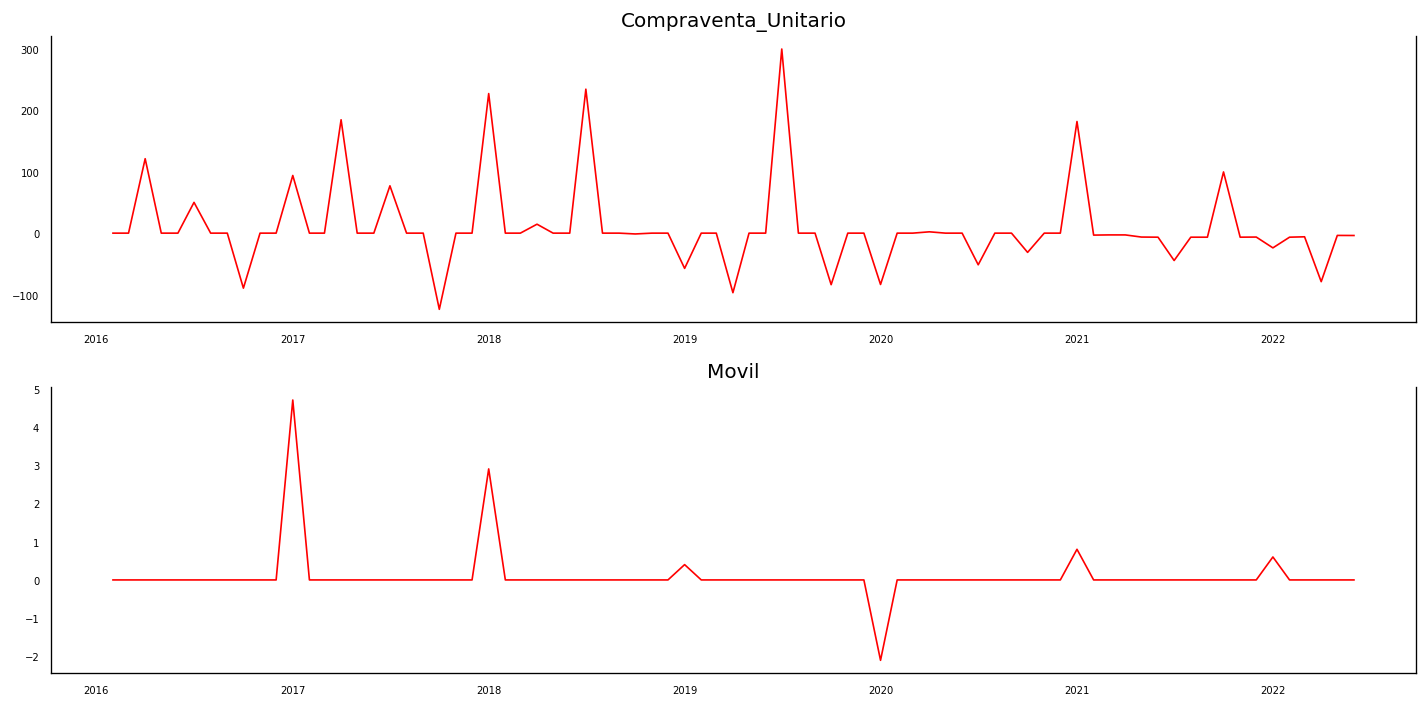

In [23]:
# Plot
fig, axes = plt.subplots(nrows=2, ncols=1, dpi=120, figsize=(12,6))
for i, ax in enumerate(axes.flatten()):
    data = X_train_transformed[X_train_transformed.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(X_train_transformed.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [24]:
print('Test de Dickey-Fuller Aumentado 2da vez:')
for i in range(len(X_train_transformed.columns)):
  print('Serie de tiempo transformada', 'Variable', X_train_transformed.columns[i])
  augmented_dickey_fuller_statistics(X_train_transformed.iloc[:,i])

Test de Dickey-Fuller Aumentado 2da vez:
Serie de tiempo transformada Variable Compraventa_Unitario
p-value: 0.000000
Serie de tiempo transformada Variable Movil
p-value: 0.172773


Los p-valores son mayores que 0.05, con lo cual no se rechaza la hipótesis nula de que la serie no es estacionaria. Habría que transformar los datos porque no se puede confirmar estacionariedad.

In [25]:
#Diferenciando por primera vez
X_train_transformed=X_train.diff().diff().dropna()
X_train_transformed.head()

,Compraventa_Unitario,Movil
Fecha,,
2016-03-01,0.000000,0.0
2016-04-01,121.169231,0.0
2016-05-01,-121.169231,0.0
2016-06-01,0.000000,0.0
2016-07-01,50.076923,0.0


In [26]:
print('Test de Dickey-Fuller Aumentado 2da vez:')
for i in range(len(X_train_transformed.columns)):
  print('Serie de tiempo transformada', 'Variable', X_train_transformed.columns[i])
  augmented_dickey_fuller_statistics(X_train_transformed.iloc[:,i])

Test de Dickey-Fuller Aumentado 2da vez:
Serie de tiempo transformada Variable Compraventa_Unitario
p-value: 0.000001
Serie de tiempo transformada Variable Movil
p-value: 0.000000


Todos los p-valores son < 0.05 por lo tanto se podría concluir que con 2 ordenes de diferenciación se obtienen series estacionarias.

### Modelo VAR

El modelo VAR es una extension del modelo ARIMA para multiples series temporales, es decir en vez de modelar una sola srie temporal, el VAR modela simultaneamente todas las series temporales de un sistema.
Cada serie temporal se regresa en función de usus propios valores pasados y de los valores pasados de las otras series temporales.
**Es util cuando las diferentes series temporales estan interrelacionadas y se influyen mutuamente.**




In [27]:
from statsmodels.tsa.api import VAR

In [28]:
model = VAR(X_train_transformed)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


#### Seleccionando el orden del modelo

In [29]:
modelsel=model.select_order(8)
modelsel.summary()

,AIC,BIC,FPE,HQIC
0,9.182,9.247,9721.,9.208
1,8.720,8.915*,6122.,8.797
2,8.639,8.965,5650.,8.768
3,8.530,8.987,5072.,8.711
4,8.525,9.112,5054.,8.758
5,8.480,9.198,4846.,8.765
6,8.366,9.215,4341.,8.703*
7,8.372,9.351,4387.,8.760
8,8.269*,9.379,3986.*,8.709


Dependiendo del criterio que se elija, el orden óptimo del VAR varía. Para AIC y FPE, el mejor orden es 8; para BIC, el mejor orden es 1; y para HQIC, el mejor orden es 6.

#### Ajustando el modelo

In [30]:
res = model.fit(maxlags=8)
res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 18, May, 2024
Time:                     14:55:26
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    9.37861
Nobs:                     68.0000    HQIC:                   8.70857
Log likelihood:          -440.117    FPE:                    3985.84
AIC:                      8.26885    Det(Omega_mle):         2550.94
--------------------------------------------------------------------
Results for equation Compraventa_Unitario
                             coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------------
const                          -1.066048         8.146067           -0.131           0.896
L1.Compraventa_Unitario        -0.742566         0.144939           -5.123           0.000
L1.Mo

La correlación entre los residuos de "Compraventa_Unitario" y los residuos de "Movil" es de 0.371091, lo que sugiere una correlación moderada entre los residuos de estas dos variables en tu modelo.

In [31]:
res.is_stable()

True

In [32]:
X_train.columns

Index(['Compraventa_Unitario', 'Movil'], dtype='object')

###### Causalidad de Granger

In [33]:
grangercaus=res.test_causality(['Movil'],['Compraventa_Unitario'],kind='f')
grangercaus.summary()

Test statistic,Critical value,p-value,df
1.657,2.030,0.118,"(8, 102)"


In [34]:
grangercaus=res.test_causality(['Compraventa_Unitario'],['Movil'],kind='f')
grangercaus.summary()

Test statistic,Critical value,p-value,df
3.858,2.030,0.001,"(8, 102)"


Como se puede observar, la causalidad de Granger nos indica que ninguna de las series temporales puede predecir la otra serie temporal

###### Matriz de causalidad de Granger


In [35]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import grangercausalitytests
import warnings
warnings.filterwarnings("ignore")
maxlag=21
test = 'ssr_chi2test'
def grangers_causality_matrix(X_train_transformed, variables, test = 'ssr_chi2test', verbose=False):
  dataset = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
  for c in dataset.columns:
    for r in dataset.index:
      test_result = grangercausalitytests(X_train_transformed[[r,c]], maxlag=maxlag, verbose=False)
      p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
      if verbose:
        print(f'Y = {r}, X = {c}, P Values = {p_values}')
      min_p_value = np.min(p_values)
      dataset.loc[r,c] = min_p_value
  dataset.columns = [var + '_x' for var in variables]
  dataset.index = [var + '_y' for var in variables]
  return dataset
grangers_causality_matrix(X_train_transformed, variables = X_train_transformed.columns)

,Compraventa_Unitario_x,Movil_x
Compraventa_Unitario_y,1.0,0.0
Movil_y,0.0,1.0


Con esta matriz queda claro que la serie temporal de Compraventa_Unitario no causa ni es causada por la otra serie temporal de ParadosReg

#### Diagnosis del modelo


###### Residuos

In [36]:
residuals=res.resid

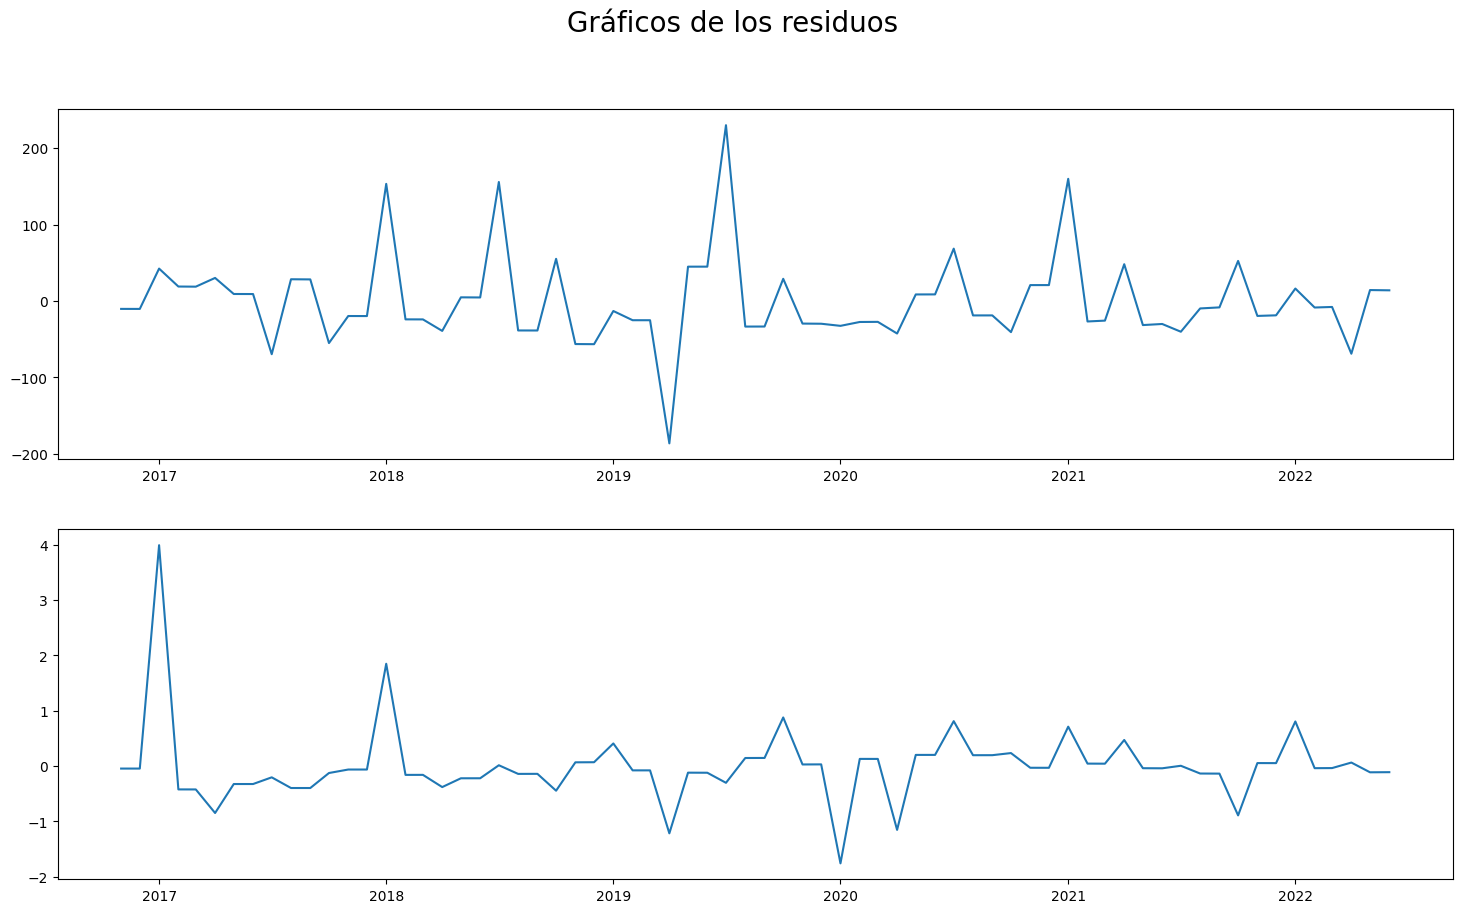

In [37]:
fig, axs = plt.subplots(2)
fig.suptitle('Gráficos de los residuos',fontsize=20)
fig.set_size_inches(18, 10)
[axs[i].plot(residuals.iloc[:,i]) for i in range(2)]
plt.show()

###### Dickey - Fuller a los residuos


In [38]:
print('ADF de los Residuos, p-valores:')
[sts.adfuller(residuals.iloc[:,i])[1] for i in range(2)]

ADF de los Residuos, p-valores:


[3.705894288289217e-13, 9.39755355411504e-13]

Todos los p-valores son < 0.1 por tanto se rechaza la hipótesis nula de que las 3 series de residuos no son estacionarias, por lo cual con un 90% de confianza se cree que son estacionarias.



###### ACF de los Residuos


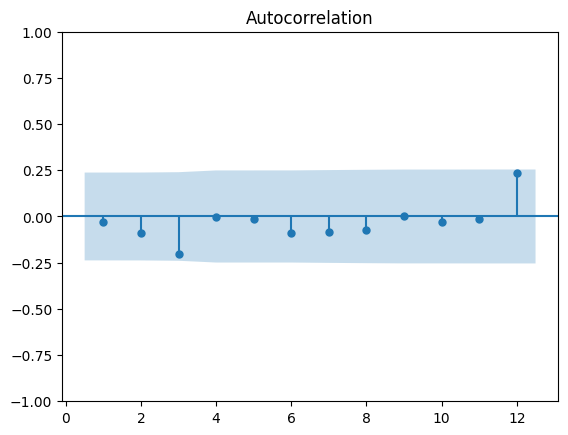

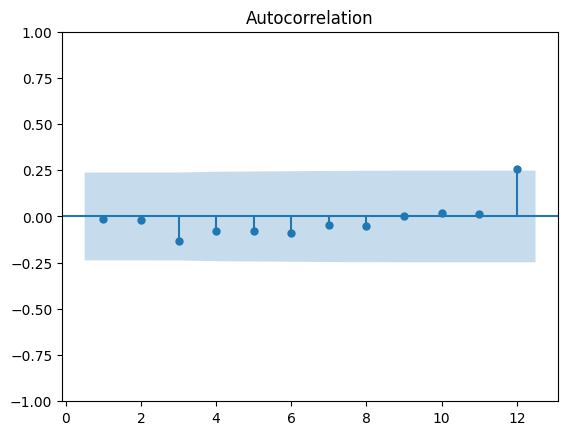

In [39]:
import statsmodels.graphics.tsaplots as sgt
[sgt.plot_acf(residuals.iloc[:,i], zero = False, lags = 12) for i in range(2)]
plt.show()

Se observa que casi todos los puntos están dentro del intervalo de confianza hasta el rezago 11, lo que sugiere que no hay autocorrelaciones significativas para esos rezagos. Esto es un buen indicio y sugiere que el modelo está adecuadamente especificado para estos rezagos.

El punto en el rezago 12 que sale del intervalo de confianza indica una autocorrelación significativa. Este es un hallazgo importante que puede sugerir varias cosas:

- Subespecificación del Modelo: Es posible que el modelo necesite más rezagos para capturar adecuadamente la dinámica subyacente de las series temporales, especialmente si hay una periodicidad o estacionalidad no capturada por el modelo actual.
- Estructura Estacional: Si el modelo no incluyó términos para manejar la estacionalidad y los datos son estacionales (como datos mensuales con patrones anuales), esto podría explicar por qué se detecta autocorrelación a este rezago.


In [40]:
res = model.fit(maxlags=12)
res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 18, May, 2024
Time:                     14:55:30
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    8.72524
Nobs:                     64.0000    HQIC:                   7.70306
Log likelihood:          -356.860    FPE:                    1244.22
AIC:                      7.03861    Det(Omega_mle):         643.392
--------------------------------------------------------------------
Results for equation Compraventa_Unitario
                              coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------
const                           -2.326463         8.474836           -0.275           0.784
L1.Compraventa_Unitario         -0.854715         0.170387           -5.016           0.000
L

In [41]:
residuals=res.resid

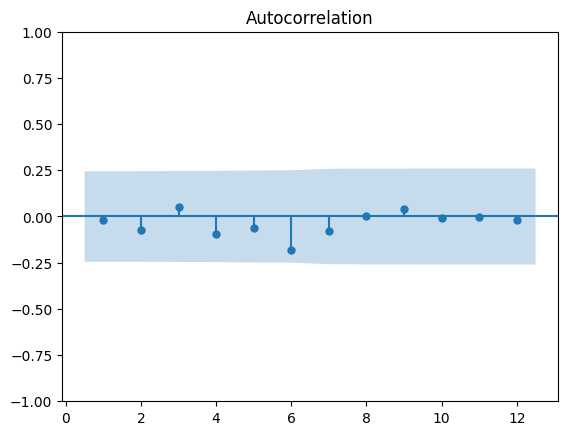

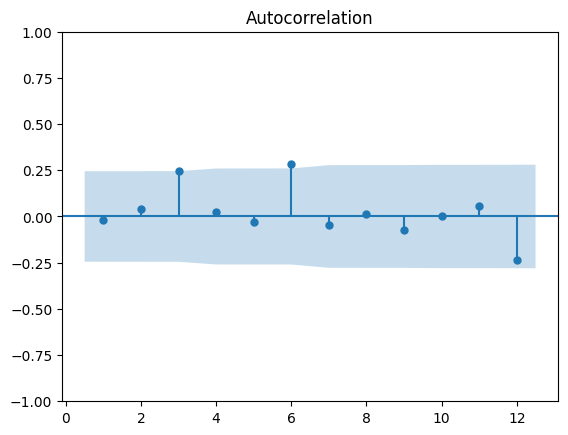

In [42]:
import statsmodels.graphics.tsaplots as sgt
[sgt.plot_acf(residuals.iloc[:,i], zero = False, lags = 12) for i in range(2)]
plt.show()


Probaremos seguidamente con el numero de rezagos igual a 6

In [43]:
res = model.fit(maxlags=6)
res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 18, May, 2024
Time:                     14:55:31
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    9.13742
Nobs:                     70.0000    HQIC:                   8.63400
Log likelihood:          -463.231    FPE:                    4068.32
AIC:                      8.30226    Det(Omega_mle):         2893.71
--------------------------------------------------------------------
Results for equation Compraventa_Unitario
                             coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------------
const                          -1.518392         8.256251           -0.184           0.854
L1.Compraventa_Unitario        -0.554863         0.126567           -4.384           0.000
L1.Mo

In [44]:
residuals=res.resid

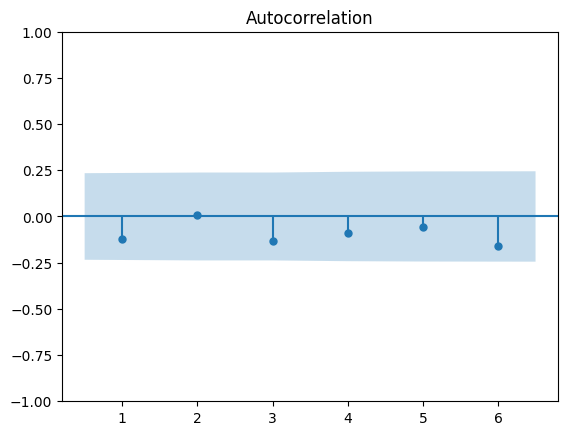

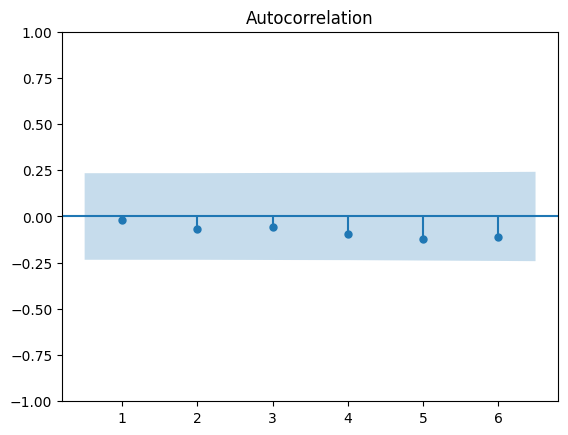

In [45]:
import statsmodels.graphics.tsaplots as sgt
[sgt.plot_acf(residuals.iloc[:,i], zero = False, lags = 6) for i in range(2)]
plt.show()

Se observa que todos los puntos están dentro del intervalo de confianza hasta el rezago 6, lo que sugiere que no hay autocorrelaciones significativas para esos rezagos. Esto es un buen indicio y sugiere que el modelo está adecuadamente especificado para estos rezagos.



#### Valores predichos


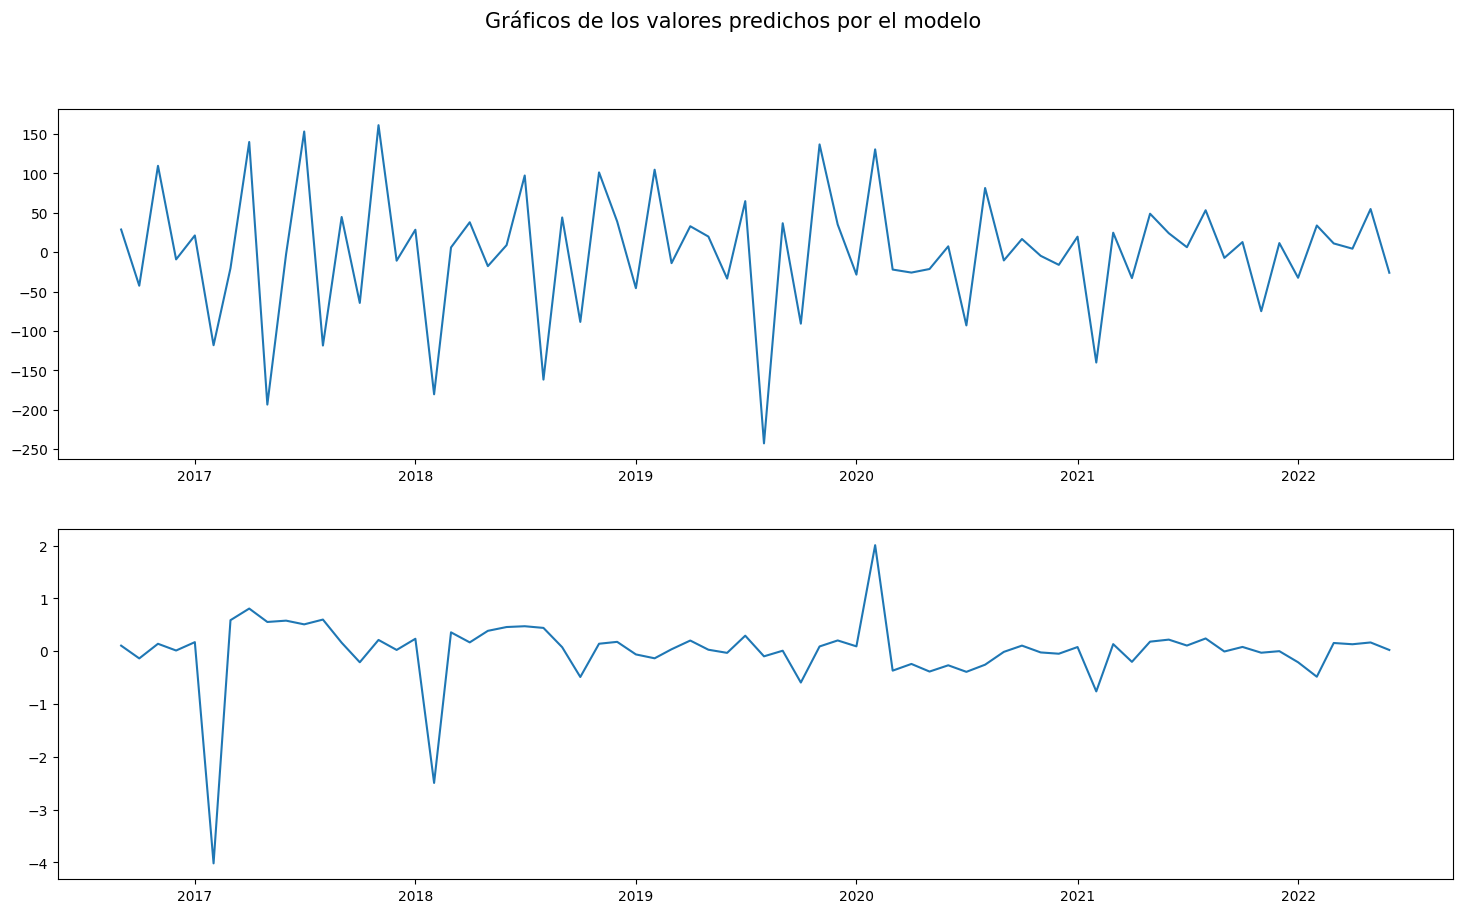

In [46]:
y_fitted = res.fittedvalues
fig, axs = plt.subplots(2)
fig.suptitle('Gráficos de los valores predichos por el modelo',fontsize=15)
fig.set_size_inches(18, 10)
[axs[i].plot(y_fitted.iloc[:,i]) for i in range(2)]
plt.show()

#### Pronósticos a futuro


In [47]:
# Obtener el orden del modelo
lag_order = res.k_ar
print('Orden del modelo:', lag_order)
# Input data para hacer forecasting (pronósticos a futuro)
input_data = X_train_transformed.values[-lag_order:]
# Forecasting
pred = res.forecast(y=input_data, steps=6)
pred = (pd.DataFrame(pred, index=X_test.index, columns=X_test.columns + '_pred'))
print('Predicciones:')
pred

Orden del modelo: 6
Predicciones:


,Compraventa_Unitario_pred,Movil_pred
Fecha,,
2022-07-01,57.651575,0.271959
2022-08-01,-97.056285,-0.243173
2022-09-01,15.963510,-0.027118
2022-10-01,6.192909,-0.050296
2022-11-01,12.313970,0.125769
2022-12-01,-3.825889,0.024236


<Figure size 1200x1000 with 0 Axes>

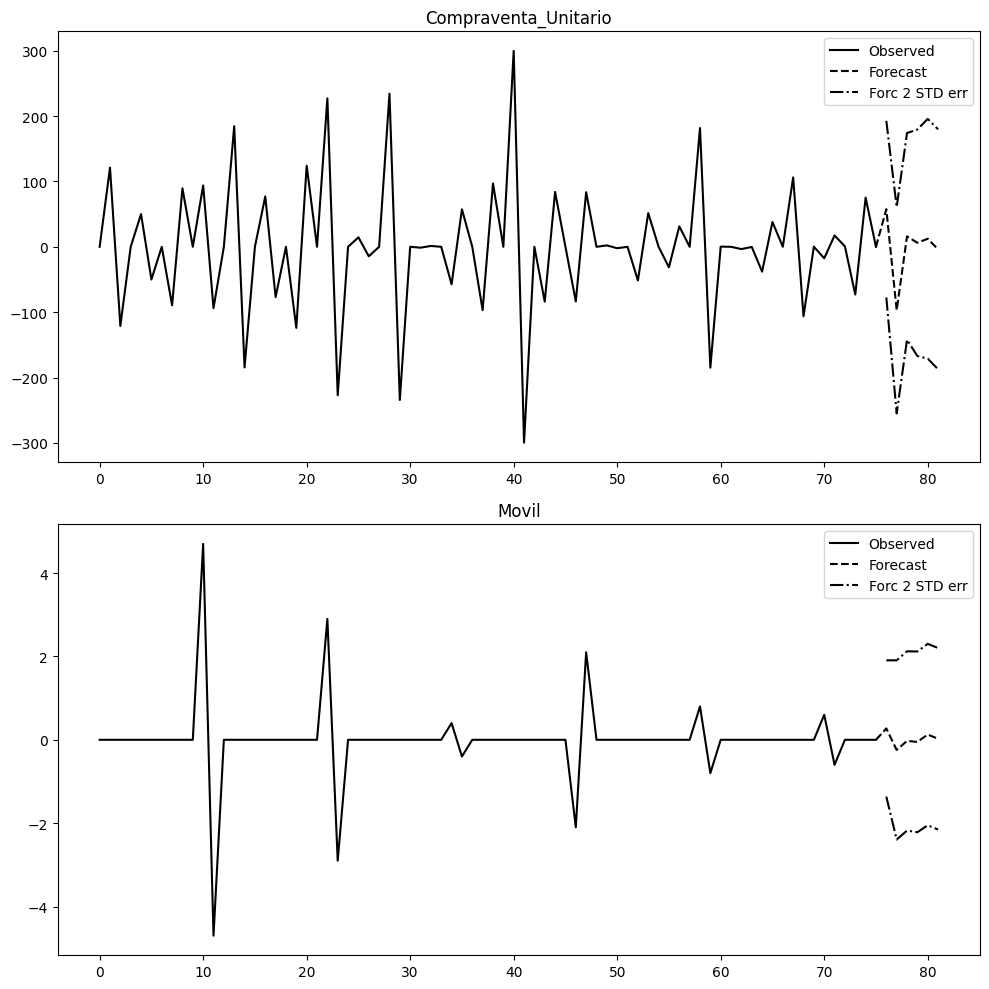

In [48]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12, 10))
res.plot_forecast(lag_order)
plt.tight_layout(h_pad = 1.15)
plt.show()


#### Invirtiendo la transformación de los pronósticos a la escala original


Los pronósticos se generan en la escala de los datos de entrenamiento utilizados por el modelo, es decir, son datos transformados. Entonces, para volver a ponerlos en su escala original, necesitamos des-diferenciarlos. La forma de invertir la diferenciación es sumar estas diferencias consecutivamente al número base. Una forma sencilla de hacerlo es determinar primero la suma acumulada y luego sumarla al número base. Este proceso se puede revertir agregando la observación en el paso de tiempo anterior al difference value. inverted(ts) = differenced(ts) + observation(ts-1)



In [49]:
# Invirtiendo la transformación teniendo en cuenta que hemos diferenciado dos veces
def invert_transformation(ds, df_forecast, second_diff=False):
    for col in ds.columns:
        # Undo the 2nd Differencing
        if second_diff:
            # Add back the first difference to the forecast
            df_forecast[str(col)] = (ds[col].iloc[-1] - ds[col].iloc[-2]) + df_forecast[str(col)].cumsum()


        # Undo the 1st Differencing
        df_forecast[str(col)] = ds[col].iloc[-1] + df_forecast[str(col)].cumsum()

    return df_forecast

In [50]:
pred.columns=X_test.columns
output = invert_transformation(X_train, pred, second_diff=True)
output

,Compraventa_Unitario,Movil
Fecha,,
2022-07-01,2316.510262,98.771959
2022-08-01,2273.267361,98.800744
2022-09-01,2245.987970,98.802412
2022-10-01,2224.901488,98.753783
2022-11-01,2216.128977,98.830924
2022-12-01,2203.530577,98.932300


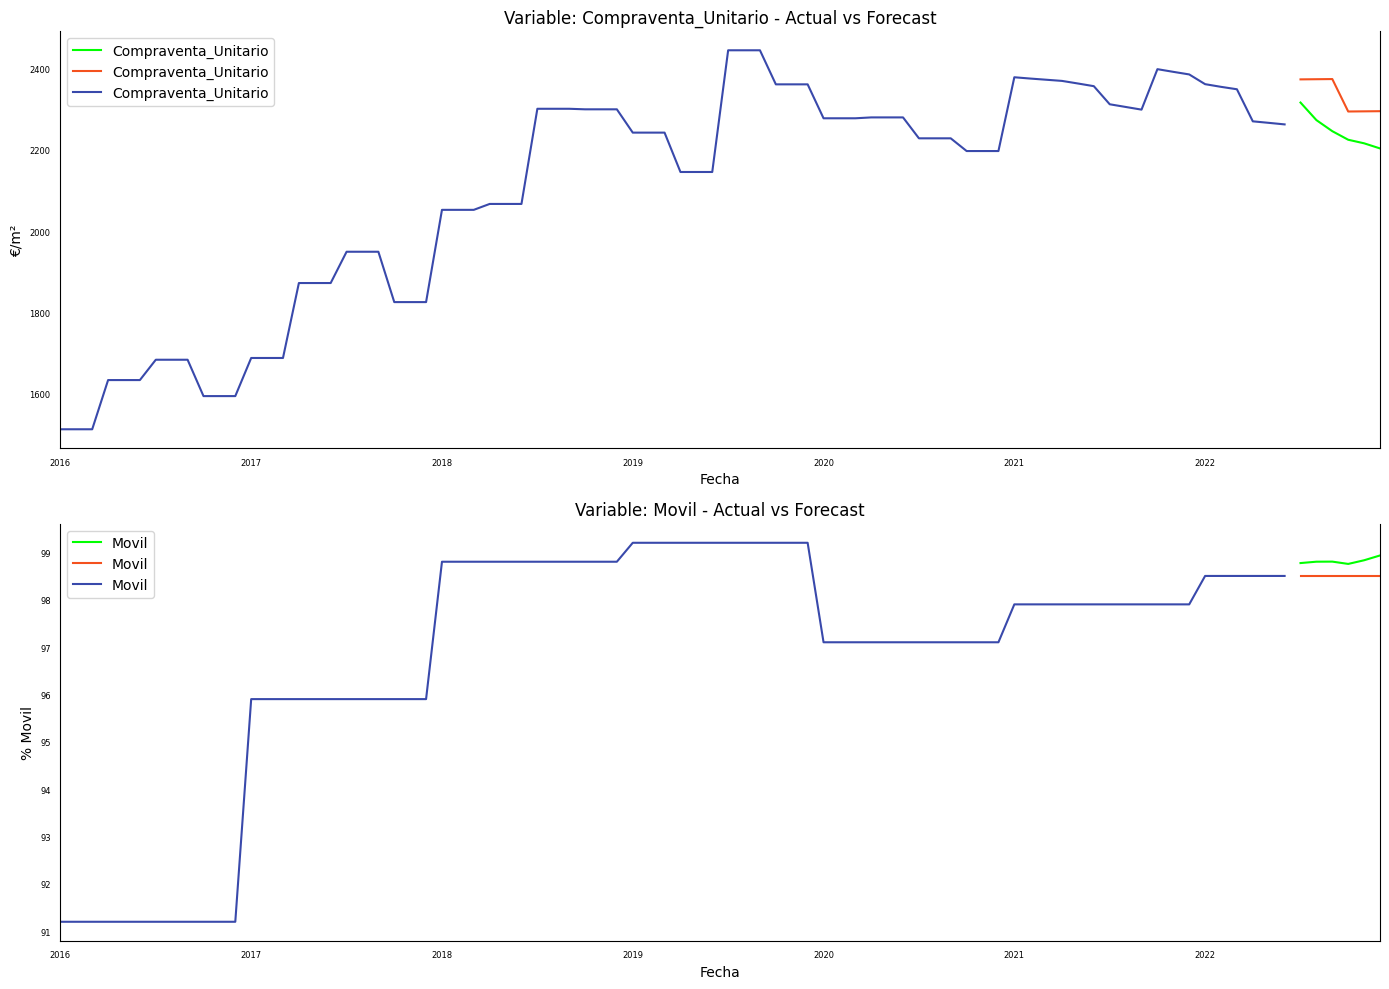

In [51]:
# Actual vs Forecasted Plots
fig, axes = plt.subplots(nrows = int(len(X_train.columns)), ncols = 1, dpi = 100, figsize = (14,10))
mi_lista = ['€/m²','% Movil']

for i, (col,ax) in enumerate(zip(X_train.columns, axes.flatten())):
    output[col].plot(color = '#00FF00', legend = True, ax = ax).autoscale(axis =' x',tight = True)
    X_test[col].plot(color = '#F4511E', legend = True, ax = ax)
    X_train[col].plot(color = '#3949AB', legend = True, ax = ax)

    ax.set_title('Variable: ' + col + ' - Actual vs Forecast')
    ax.set_ylabel(mi_lista[i])  # Establecer etiqueta del eje y
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize = 6)

plt.tight_layout()
plt.savefig('actual_forecast.png')
plt.show()

#### Evaluando el modelo


In [52]:
def timeseries_evaluation_metrics_func(y_true, y_pred):

    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [53]:
for i in ['Compraventa_Unitario','Movil']:
    print(f'Evaluation metric for {i}')
    timeseries_evaluation_metrics_func(X_test[str(i)] , output[str(i)])

Evaluation metric for Compraventa_Unitario
Evaluation metric results:-
MSE is : 8218.556317438479
MAE is : 87.67834151319487
RMSE is : 90.6562536035903
MAPE is : 3.751314217440329
R2 is : -4.2520543039236065

Evaluation metric for Movil
Evaluation metric results:-
MSE is : 0.10277690239703086
MAE is : 0.3153536256576028
RMSE is : 0.32058836909194144
MAPE is : 0.3201559651346221
R2 is : 0.0



Los resultados para Compraventa_Unitario indican un desempeño muy pobre del modelo, con un R² de -6.50, señalando que el modelo es considerablemente peor que un simple modelo de la media. Los valores elevados de MSE, MAE y RMSE muestran grandes errores en las predicciones, y un MAPE del 4.45% refleja una precisión relativa moderada, aunque la significancia general del modelo es cuestionable debido al R² negativo.

En cuanto a Movil, aunque las métricas MSE, MAE y RMSE son relativamente bajas, indicando pequeños errores numéricos en las predicciones, un R² de 0.0 sugiere que el modelo no mejora las predicciones más allá de un simple promedio. El MAPE de 0.38% es bajo, mostrando buena precisión relativa en términos porcentuales. La falta de mejora en R² podría sugerir que el modelo no captura ninguna de las variabilidades explicativas en los datos, posiblemente debido a la ausencia de variabilidad inherente en la serie o a una especificación de modelo inadecuada.

In [54]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
print('Mean absolute error:', mean_absolute_error(X_test, output))
print('Root mean squared error:', np.sqrt(mean_squared_error(X_test, output)))

Mean absolute error: 43.99684756942624
Root mean squared error: 64.10405250193187


###Modelo VECM (Vector Error Correction Model)

####Ajustando el modelo

In [55]:
from statsmodels.tsa.vector_ar.vecm import select_order

In [56]:
# Seleccionar el número óptimo de retardos basado en criterios de información
order_selection = select_order(X_train, maxlags=12) #Dado que una de las series tiene datos trimestrales(8) y la otra anual(30)
print(order_selection.summary())

 VECM Order Selection (* highlights the minimums) 
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        6.785      6.986*      884.8*      6.864*
1        6.885       7.220       978.5       7.017
2        6.977       7.445       1073.       7.162
3        7.005       7.607       1106.       7.243
4        7.105       7.841       1226.       7.395
5        7.196       8.066       1349.       7.539
6        6.882       7.886       991.7       7.278
7        6.983       8.120       1105.       7.432
8        7.075       8.346       1224.       7.576
9        7.051       8.456       1211.       7.605
10       7.148       8.687       1356.       7.755
11       7.236       8.909       1510.       7.896
12      6.685*       8.492       890.7       7.398
--------------------------------------------------


In [57]:
from statsmodels.tsa.vector_ar.vecm import VECM

In [69]:
# Usar el número óptimo de retardos seleccionado
optimal_lags = order_selection.aic  # Por ejemplo, puedes usar el criterio AIC
model = VECM(X_train, k_ar_diff=optimal_lags)

In [70]:
vecm_fit = model.fit()

In [71]:
vecm_fit.summary()

,coef,std err,z,P>|z|,[0.025,0.975]
L1.Compraventa_Unitario,0.0202,0.120,0.169,0.866,-0.214,0.255
L1.Movil,-7.5156,10.227,-0.735,0.462,-27.559,12.528
L2.Compraventa_Unitario,0.0193,0.120,0.162,0.872,-0.215,0.254
L2.Movil,-7.4563,10.225,-0.729,0.466,-27.498,12.585
L3.Compraventa_Unitario,-0.6820,0.122,-5.592,0.000,-0.921,-0.443
L3.Movil,25.4974,10.244,2.489,0.013,5.419,45.576
L4.Compraventa_Unitario,-0.0234,0.140,-0.167,0.867,-0.298,0.251
L4.Movil,-7.2827,10.666,-0.683,0.495,-28.188,13.622
L5.Compraventa_Unitario,-0.0250,0.140,-0.179,0.858,-0.299,0.249
L5.Movil,-7.2404,10.665,-0.679,0.497,-28.143,13.662


El análisis indica que las dos series están cointegradas y tienen una relación dinámica de ajuste hacia un equilibrio común. Los resultados sugieren que ajustes en "Movil" tienen un efecto significativo en "Compraventa_Unitario", mientras que los ajustes en "Compraventa_Unitario" tienen un impacto relativamente menor en "Movil" basado en los coeficientes de carga más pequeños.

In [72]:
stability_test = vecm_fit.test_whiteness(nlags=13)
print(stability_test.summary())

Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 13 is zero. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         32.05          5.991   0.000  2
----------------------------------------


###Diagnosis del modelo

####Residuos

In [73]:
residuals=vecm_fit.resid

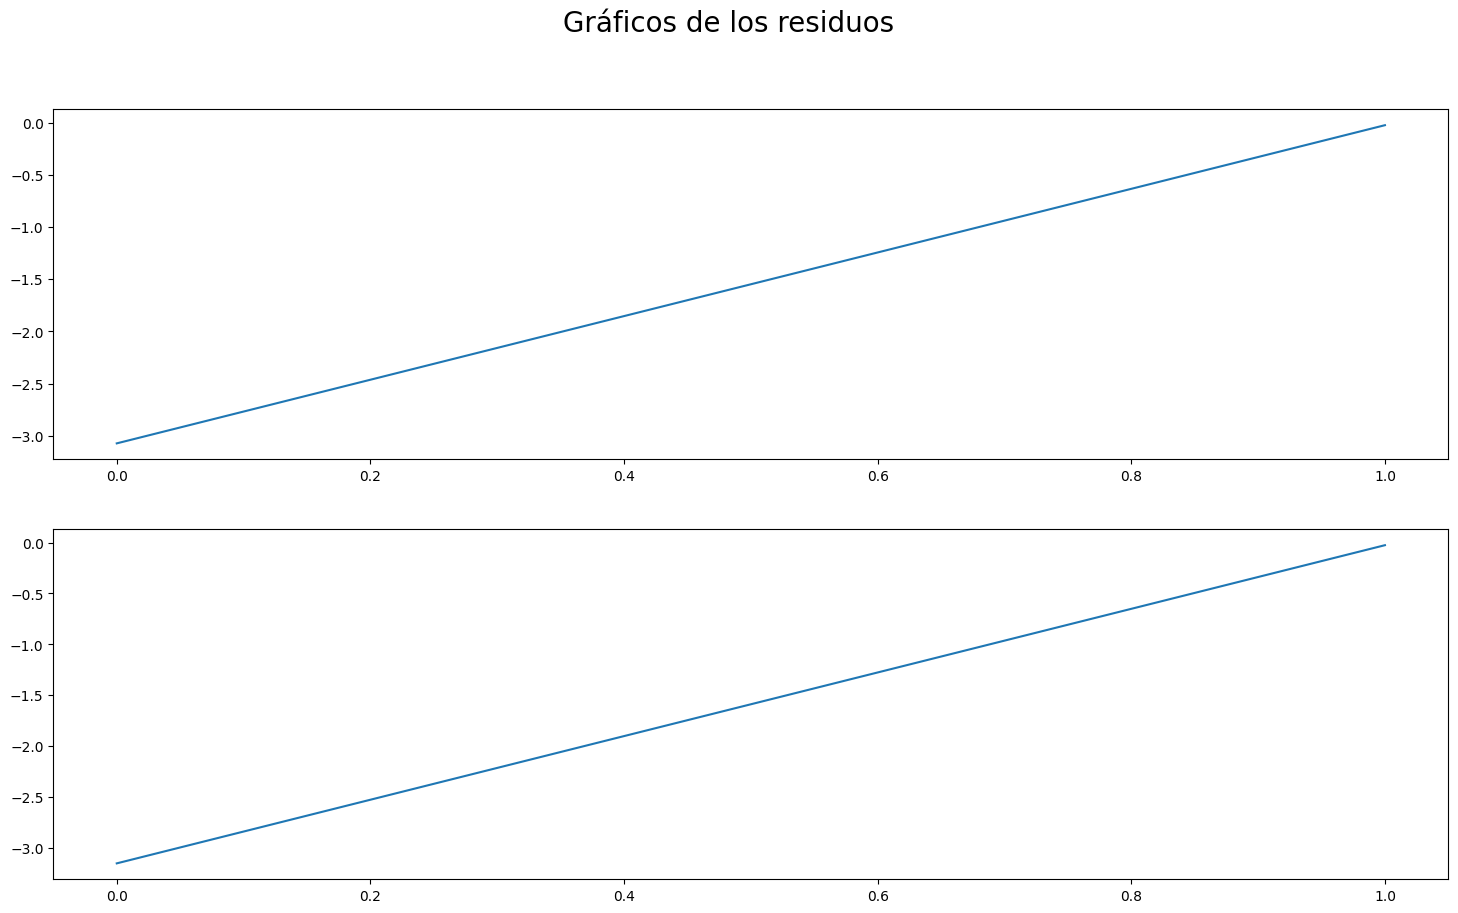

In [74]:
fig, axs = plt.subplots(2)
fig.suptitle('Gráficos de los residuos',fontsize=20)
fig.set_size_inches(18, 10)
[axs[i].plot(residuals[i]) for i in range(2)]
plt.show()

####Dickey - Fuller a los residuos

In [75]:
import statsmodels.tsa.stattools as ts

In [76]:
# Realizar la prueba ADF en cada serie de residuos y imprimir los resultados
print('ADF de los Residuos, p-valores:')
for i in range(residuals.shape[1]):
    result = ts.adfuller(residuals[:, i])
    print(f'Variable {i+1}: Estadístico ADF = {result[0]:.4f}, P-valor = {result[1]:.4f}')

ADF de los Residuos, p-valores:
Variable 1: Estadístico ADF = -7.8224, P-valor = 0.0000
Variable 2: Estadístico ADF = -3.2763, P-valor = 0.0160


####ACF de los Residuos

In [77]:
import statsmodels.api as sm

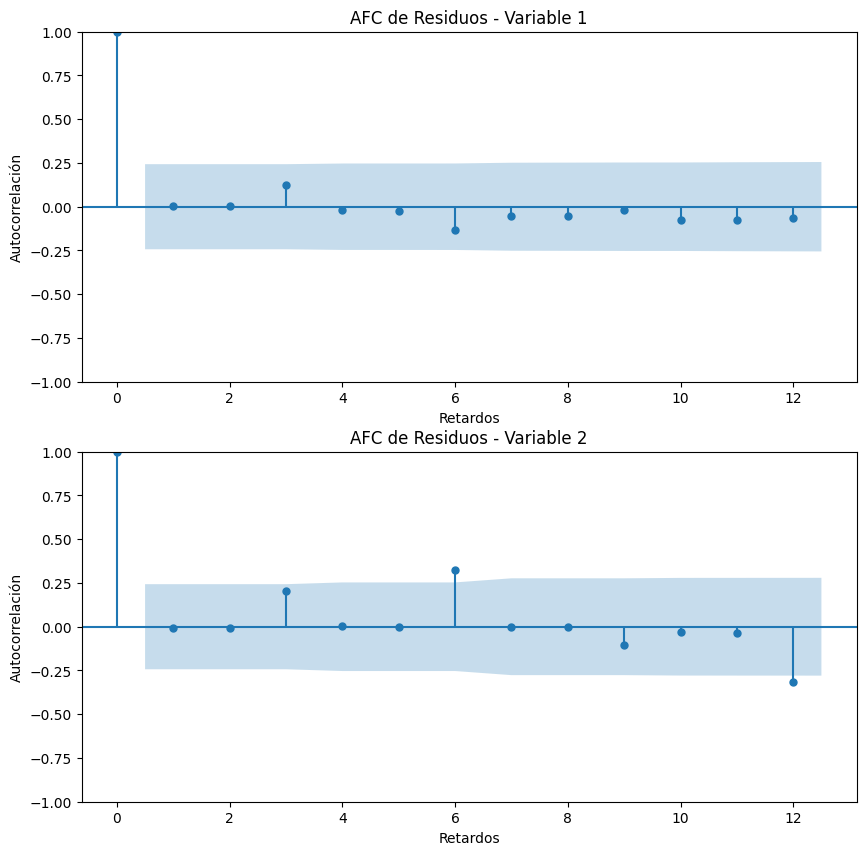

In [78]:
# Realizar y graficar la función de autocorrelación para cada serie de residuos
fig, axes = plt.subplots(nrows=residuals.shape[1], ncols=1, figsize=(10, 10))
for i in range(residuals.shape[1]):
    sm.graphics.tsa.plot_acf(residuals[:, i], lags=12, ax=axes[i], title=f'AFC de Residuos - Variable {i+1}')
    axes[i].set_ylabel('Autocorrelación')
    axes[i].set_xlabel('Retardos')

Esto sugiere que los residuos de la Variable 1 y 2 son aproximadamente ruido blanco, exceptuando en el retardo 6, por lo que probaremos a entrenar un modelo con 6 retardos.

In [79]:
# Usar el número óptimo de retardos seleccionado
optimal_lags = order_selection.aic  # Por ejemplo, puedes usar el criterio AIC
model = VECM(X_train, k_ar_diff=6)

In [80]:
vecm_fit = model.fit()

In [81]:
vecm_fit.summary()

,coef,std err,z,P>|z|,[0.025,0.975]
L1.Compraventa_Unitario,0.0228,0.099,0.230,0.818,-0.171,0.217
L1.Movil,-7.3644,9.883,-0.745,0.456,-26.734,12.005
L2.Compraventa_Unitario,0.0230,0.099,0.233,0.816,-0.171,0.217
L2.Movil,-7.3627,9.886,-0.745,0.456,-26.738,12.013
L3.Compraventa_Unitario,-0.5331,0.101,-5.281,0.000,-0.731,-0.335
L3.Movil,30.9714,9.903,3.127,0.002,11.561,50.382
L4.Compraventa_Unitario,-0.0256,0.096,-0.267,0.790,-0.214,0.163
L4.Movil,-4.3596,9.898,-0.440,0.660,-23.758,15.039
L5.Compraventa_Unitario,-0.0256,0.096,-0.267,0.790,-0.214,0.163
L5.Movil,-4.3739,9.899,-0.442,0.659,-23.776,15.028


In [82]:
residuals=vecm_fit.resid

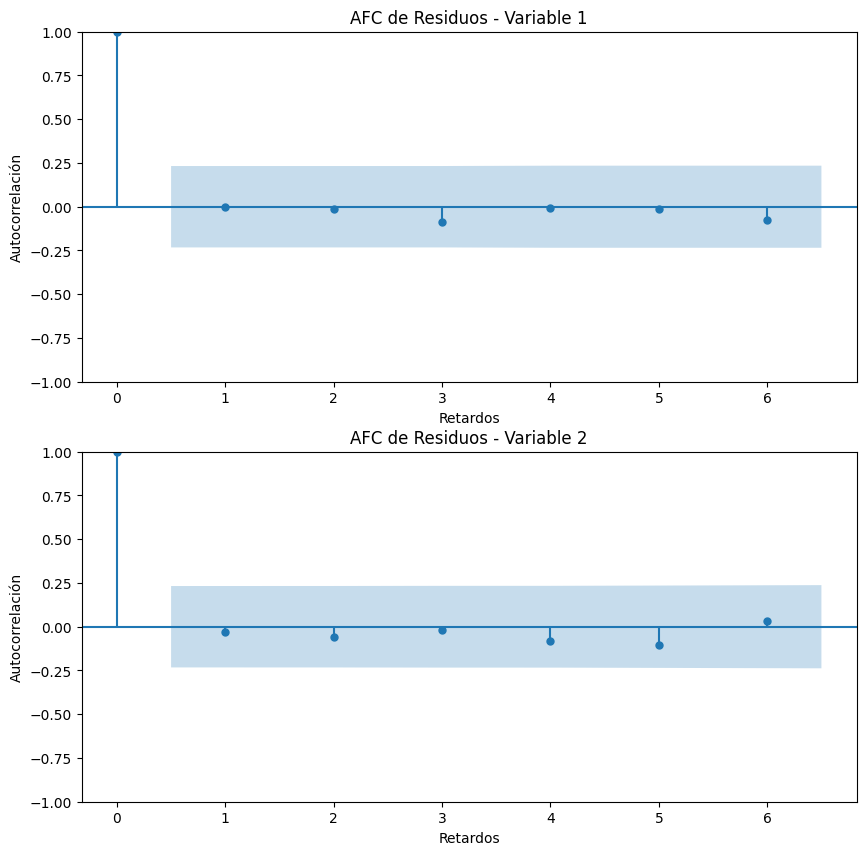

In [83]:
# Realizar y graficar la función de autocorrelación para cada serie de residuos
fig, axes = plt.subplots(nrows=residuals.shape[1], ncols=1, figsize=(10, 10))
for i in range(residuals.shape[1]):
    sm.graphics.tsa.plot_acf(residuals[:, i], lags=6, ax=axes[i], title=f'AFC de Residuos - Variable {i+1}')
    axes[i].set_ylabel('Autocorrelación')
    axes[i].set_xlabel('Retardos')

Esto sugiere que los residuos de la Variable 1 y 2 son aproximadamente ruido blanco,para un modelo de 6 retardos

###Valores predichos

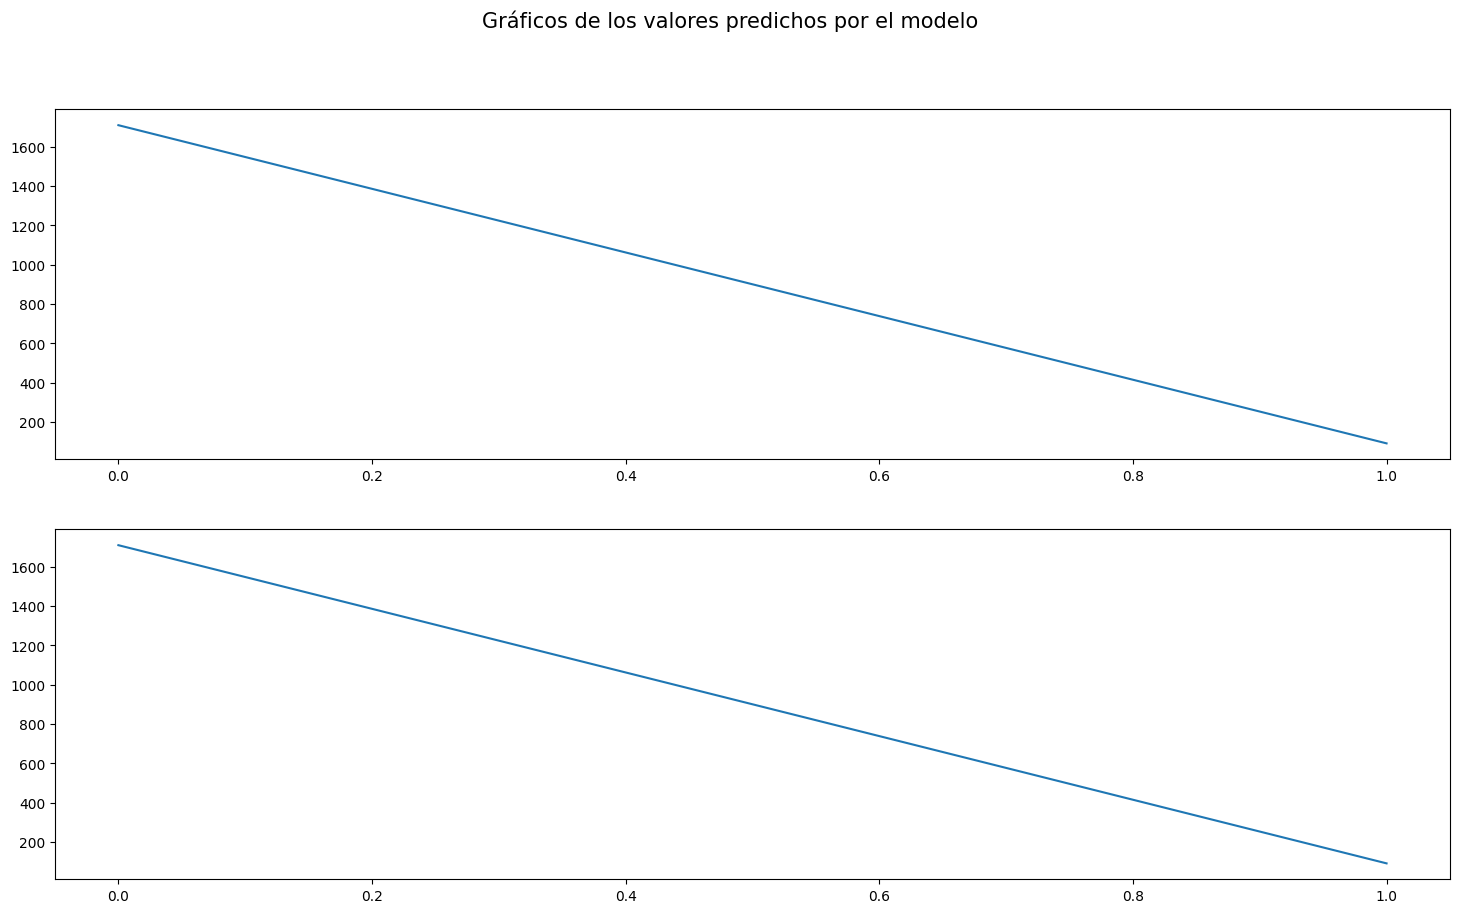

In [84]:
y_fitted = vecm_fit.fittedvalues
fig, axs = plt.subplots(2)
fig.suptitle('Gráficos de los valores predichos por el modelo',fontsize=15)
fig.set_size_inches(18, 10)
[axs[i].plot(y_fitted[i]) for i in range(2)]
plt.show()

###Pronósticos a futuro

In [85]:
# Obtener los últimos valores (lag_order número de valores)
lag_order = vecm_fit.k_ar
last_observations = data[-lag_order:]

# Hacer predicciones para los próximos n pasos
n_steps = 6
forecast = vecm_fit.predict(n_steps)

pred = (pd.DataFrame(forecast, index=X_test.index, columns=X_test.columns))
pred

,Compraventa_Unitario,Movil
Fecha,,
2022-07-01,2354.054466,98.791400
2022-08-01,2360.096506,98.833995
2022-09-01,2365.528984,98.866180
2022-10-01,2356.068613,98.764305
2022-11-01,2351.811105,98.675425
2022-12-01,2347.956898,98.596737


<Figure size 1200x1000 with 0 Axes>

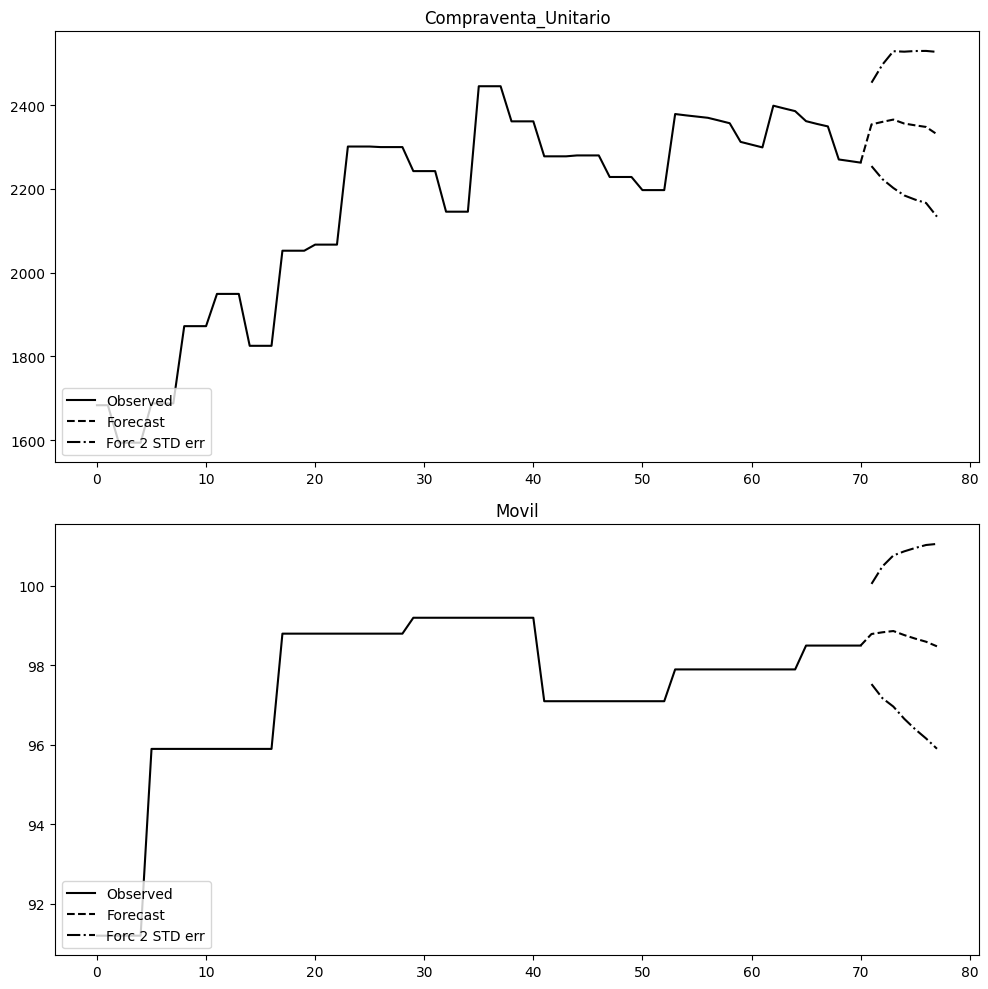

In [86]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12, 10))
vecm_fit.plot_forecast(lag_order)
plt.tight_layout(h_pad = 1.15)
plt.show()

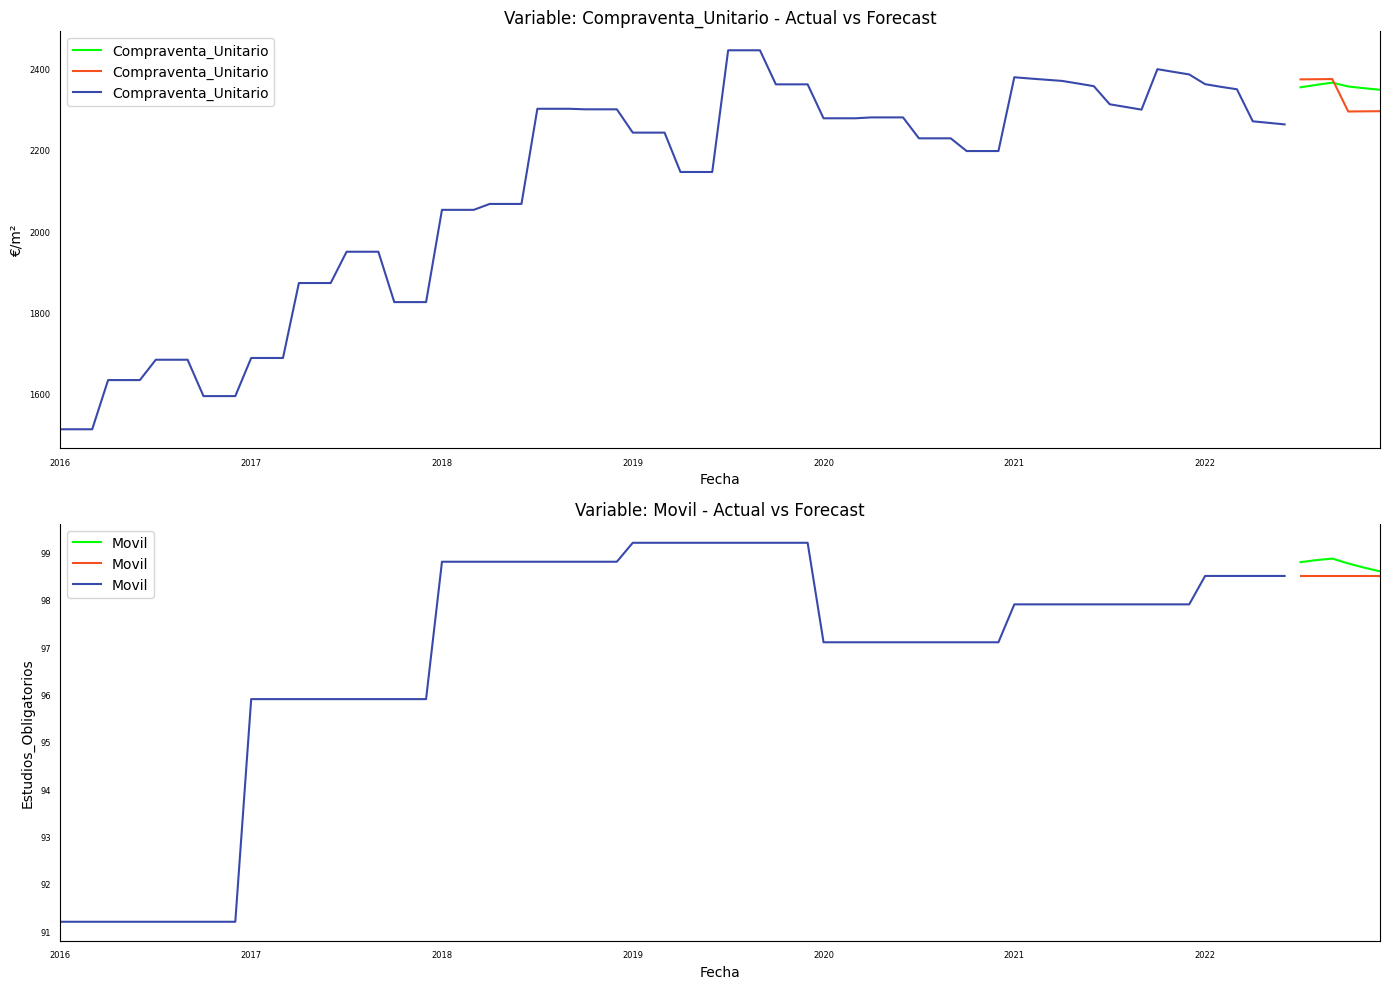

In [87]:
# Actual vs Forecasted Plots
fig, axes = plt.subplots(nrows = int(len(X_train.columns)), ncols = 1, dpi = 100, figsize = (14,10))
mi_lista = ['€/m²', 'Estudios_Obligatorios']

for i, (col,ax) in enumerate(zip(X_train.columns, axes.flatten())):
    pred[col].plot(color = '#00FF00', legend = True, ax = ax).autoscale(axis =' x',tight = True)
    X_test[col].plot(color = '#F4511E', legend = True, ax = ax)
    X_train[col].plot(color = '#3949AB', legend = True, ax = ax)

    ax.set_title('Variable: ' + col + ' - Actual vs Forecast')
    ax.set_ylabel(mi_lista[i])  # Establecer etiqueta del eje y
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize = 6)

plt.tight_layout()
plt.savefig('actual_forecast.png')
plt.show()

###Evaluando el modelo

In [88]:
def timeseries_evaluation_metrics_func(y_true, y_pred):

    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')


In [89]:
for i in ['Compraventa_Unitario','Movil']:
    print(f'Evaluation metric for {i}')
    timeseries_evaluation_metrics_func(X_test[str(i)] , pred[str(i)])

Evaluation metric for Compraventa_Unitario
Evaluation metric results:-
MSE is : 1745.3591753161181
MAE is : 35.582753809546226
RMSE is : 41.77749603932862
MAPE is : 1.5403651255854571
R2 is : -0.11536878431571229

Evaluation metric for Movil
Evaluation metric results:-
MSE is : 0.07342387822139791
MAE is : 0.25467352670963805
RMSE is : 0.27096840816116907
MAPE is : 0.25855180376613
R2 is : 0.0



Los resultados de Compraventa_Unitario muestran que el modelo sigue siendo extremadamente ineficaz, con un R² de -6.95, lo que indica que es mucho peor que un modelo basado en la media simple. Los altos valores de MSE, MAE, y RMSE refuerzan la falta de precisión en las predicciones, mientras que un MAPE del 4.93% sugiere errores significativos en relación con los valores reales de la serie.

Para Movil, las métricas como MSE, MAE, y RMSE son bajas, lo que indica errores numéricamente pequeños, pero un R² de 0.0 sugiere que el modelo no proporciona una mejora en la predicción comparado con un modelo de la media. El MAPE extremadamente bajo del 0.33% muestra una alta precisión relativa de las predicciones, aunque esto debe ser interpretado con cautela dada la incapacidad del modelo para mejorar sobre un modelo de promedio.

In [90]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
print('Mean absolute error:', mean_absolute_error(X_test, pred))
print('Root mean squared error:', np.sqrt(mean_squared_error(X_test, pred)))

Mean absolute error: 17.918713668127932
Root mean squared error: 29.54177211335112


##Conclusiones

Como conclusiones de realizar un analisis de datos forecasting a los datos de distrito de **Nou Barris** de Barcelona entre las dos series temporales de Compraventa_unitario y Movil, tenemos que:

- Se ha comprobado que las variables tienen alta correlacion.
- Se ha realizado el test de Cointegracion y se ha demostrado que una de las series Compraventa_unitario esta cointegrada, lo que hace mas adecuado aplicar un modelo VECM, que un modelo VARMA
- Se ha comprobado que la dos series de datos temporales tienen estacionalidad a partir del primer orden de diferenciacion, lo que las hace aptas para aplicar los dos modelos VAR.
- Modelo VAR: las metricas de evaluación del modelo VAR, son bastante satisfactorias para la serie temporal de movil y no tanto para la serie temporal de Compraventa_unitario
- Modelo VECM: las metricas de evaluación del modelo VECM, son bastante satisfactorias para la serie temporal de movil y no tanto para la serie temporal de Compraventa_unitario.


